In [ ]:
import os
from pathlib import Path

os.chdir("..")

mydir = Path("data/")
if not mydir.is_dir():
    os.makedirs("data/")

In [6]:
from pathlib import Path

for split in ["Train", "Validation", "Test"]:
    my_file = Path("data/GNNLink_hESC1000_{0}_set.csv".format(split))
    if not my_file.is_file():
        os.system('wget -O data/GNNLink_hESC1000_{0}_set.csv https://raw.githubusercontent.com/sdesignates/GNNLink/refs/heads/master/Data/Train_validation_test/hESC%201000/{0}_set.csv'.format(split))

In [2]:
import pandas as pd
train_edges = pd.read_csv("data/GNNLink_hESC1000_Train_set.csv", sep=",", header=0, index_col=0)
pos_train_edges = train_edges[train_edges.Label == 1]
neg_train_edges = train_edges[train_edges.Label == 0]

In [3]:
import torch
pos_train_edges_tensor = torch.LongTensor((pos_train_edges.TF.values,(pos_train_edges.Target.values)))
neg_train_edges_tensor = torch.LongTensor((neg_train_edges.TF.values,(neg_train_edges.Target.values)))

/tmp/ipykernel_5012/1477903634.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  pos_train_edges_tensor = torch.LongTensor((pos_train_edges.TF.values,(pos_train_edges.Target.values)))


/home/vscode/miniconda3/envs/granpy/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Mean out_degree positive edges: 348.82617889617256
Mean out_degree negative edges: 102.789398595259
Mean in_degree positive edges: 5.174455487418059
Mean in_degree negative edges: 3.0821627158326015


(<Figure size 640x480 with 2 Axes>,
 array([<Axes: title={'center': 'In Degree'}, xlabel='Degree', ylabel='Frequency'>,
        <Axes: title={'center': 'Out Degree'}, xlabel='Degree', ylabel='Frequency'>],
       dtype=object))

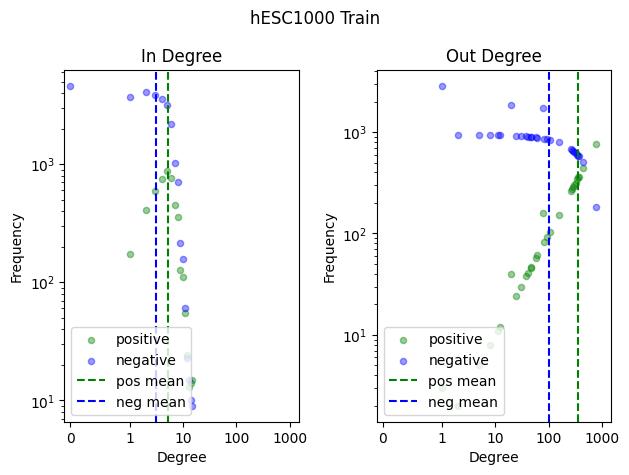

In [4]:
from src.negative_sampling import inspect_degree_bias

inspect_degree_bias(pos_train_edges_tensor, neg_train_edges_tensor, title="hESC1000 Train", plot=True)

In [5]:
from src.nn.decoders import HarmonicDegreeSorter

sorter = HarmonicDegreeSorter()
z = torch.rand((max(pos_train_edges_tensor.max(), neg_train_edges_tensor.max()) + 1, 1))

pos_out = sorter(z, pos_train_edges_tensor, pos_edge_index=pos_train_edges_tensor)
neg_out = sorter(z, neg_train_edges_tensor, pos_edge_index=pos_train_edges_tensor)

In [6]:
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np

truth = np.concatenate((np.ones_like(pos_out), np.zeros_like(neg_out)))
prediction = np.concatenate((pos_out.numpy(), neg_out.numpy()))

print("AUROC: {}".format(roc_auc_score(y_true = truth, y_score=prediction)))

AUROC: 0.8222384085134512


Mean out_degree positive edges: 401.00440933308835
Mean out_degree negative edges: 118.33295136236313
Mean in_degree positive edges: 5.849898952783391
Mean in_degree negative edges: 3.5493697478991595


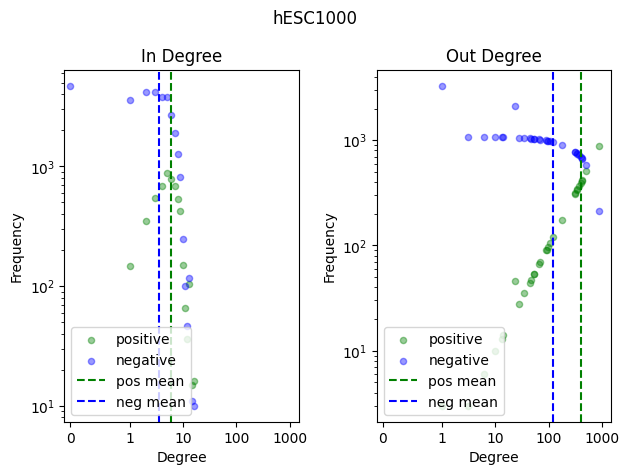

In [7]:
import pandas as pd
val_edges = pd.read_csv("data/GNNLink_hESC1000_Validation_set.csv", sep=",", header=0, index_col=0)
pos_val_edges = val_edges[val_edges.Label == 1]
neg_val_edges = val_edges[val_edges.Label == 0]
pos_val_edges_tensor = torch.LongTensor((pos_val_edges.TF.values,(pos_val_edges.Target.values)))
neg_val_edges_tensor = torch.LongTensor((neg_val_edges.TF.values,(neg_val_edges.Target.values)))

fig, ax = inspect_degree_bias(torch.hstack((pos_train_edges_tensor, pos_val_edges_tensor)), 
                    torch.hstack((neg_train_edges_tensor, neg_val_edges_tensor)),
                    title="hESC1000")

fig.savefig("hESC1000trainandval.pdf")

In [ ]:
test_edges = pd.read_csv("data/GNNLink_hESC1000_Test_set.csv", sep=",", header=0, index_col=0)
pos_test_edges = test_edges[test_edges.Label == 1]
neg_test_edges = test_edges[test_edges.Label == 0]
pos_test_edges_tensor = torch.LongTensor((pos_test_edges.TF.values,(pos_test_edges.Target.values)))
neg_test_edges_tensor = torch.LongTensor((neg_test_edges.TF.values,(neg_test_edges.Target.values)))

Mean out_degree positive edges: 119.76538695917124
Mean out_degree negative edges: 35.80586859451414
Mean in_degree positive edges: 2.489945155393053
Mean in_degree negative edges: 1.0787795024452478


/tmp/ipykernel_16420/2219307147.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  (np.arange(0, max(pos_edges.max(), neg_edges.max())),
/tmp/ipykernel_16420/2219307147.py:15: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  np.arange(0, max(pos_edges.max(), neg_edges.max())))


In [ ]:
from src.nn.decoders import HarmonicDegreeSorter

sorter = HarmonicDegreeSorter()
z = torch.rand((max(pos_train_edges_tensor.max(), neg_train_edges_tensor.max()) + 1, 1))

pos_out = sorter(z, pos_test_edges_tensor, pos_edge_index=torch.hstack((pos_train_edges_tensor, pos_val_edges_tensor)))
neg_out = sorter(z, neg_test_edges_tensor, pos_edge_index=torch.hstack((pos_train_edges_tensor, pos_val_edges_tensor)))
truth = np.concatenate((np.ones_like(pos_out), np.zeros_like(neg_out)))
prediction = np.concatenate((pos_out.numpy(), neg_out.numpy()))

print("AUROC: {}".format(roc_auc_score(y_true = truth, y_score=prediction)))
print("AUPRC: {}".format(average_precision_score(y_true = truth, y_score=prediction)))

AUROC: 0.730738726159596
AUPRC: 0.3099906481717394


In [23]:
from src.nn.decoders import OutDegreeSourceSorter

sorter = OutDegreeSourceSorter()
z = torch.rand((max(pos_train_edges_tensor.max(), neg_train_edges_tensor.max()) + 1, 1))

pos_out = sorter(z, pos_test_edges_tensor, pos_edge_index=torch.hstack((pos_train_edges_tensor, pos_val_edges_tensor)))
neg_out = sorter(z, neg_test_edges_tensor, pos_edge_index=torch.hstack((pos_train_edges_tensor, pos_val_edges_tensor)))
truth = np.concatenate((np.ones_like(pos_out), np.zeros_like(neg_out)))
prediction = np.concatenate((pos_out.numpy(), neg_out.numpy()))

print("AUROC: {}".format(roc_auc_score(y_true = truth, y_score=prediction)))
print("AUPRC: {}".format(average_precision_score(y_true = truth, y_score=prediction)))

AUROC: 0.8528920757077664
AUPRC: 0.4950709054689372


In [24]:
from src.nn.decoders import InDegreeTargetSorter

sorter = InDegreeTargetSorter()
z = torch.rand((max(pos_train_edges_tensor.max(), neg_train_edges_tensor.max()) + 1, 1))

pos_out = sorter(z, pos_test_edges_tensor, pos_edge_index=torch.hstack((pos_train_edges_tensor, pos_val_edges_tensor)))
neg_out = sorter(z, neg_test_edges_tensor, pos_edge_index=torch.hstack((pos_train_edges_tensor, pos_val_edges_tensor)))
truth = np.concatenate((np.ones_like(pos_out), np.zeros_like(neg_out)))
prediction = np.concatenate((pos_out.numpy(), neg_out.numpy()))

print("AUROC: {}".format(roc_auc_score(y_true = truth, y_score=prediction)))
print("AUPRC: {}".format(average_precision_score(y_true = truth, y_score=prediction)))

AUROC: 0.6331747482353052
AUPRC: 0.20473747349214313


In [ ]:
# to identify the set in the description of GNNLink

len(set(pos_train_edges.TF.tolist() + pos_val_edges.TF.tolist() + pos_test_edges.TF.tolist()))

34

# mESC

In [17]:
import os
from pathlib import Path

for split in ["Train", "Validation", "Test"]:
    my_file = Path("data/GNNLink_mESC1000_{0}_set.csv".format(split))
    if not my_file.is_file():
        os.system('wget -O data/GNNLink_mESC1000_{0}_set.csv https://raw.githubusercontent.com/sdesignates/GNNLink/refs/heads/master/Data/Train_validation_test/mESC%201000/{0}_set.csv'.format(split))

--2025-11-24 09:03:52--  https://raw.githubusercontent.com/sdesignates/GNNLink/refs/heads/master/Data/Train_validation_test/mESC%201000/Train_set.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1595035 (1.5M) [text/plain]
Saving to: ‘data/GNNLink_mESC1000_Train_set.csv’

     0K .......... .......... .......... .......... ..........  3% 4.51M 0s
    50K .......... .......... .......... .......... ..........  6% 11.3M 0s
   100K .......... .......... .......... .......... ..........  9% 8.07M 0s
   150K .......... .......... .......... .......... .......... 12% 20.3M 0s
   200K .......... .......... .......... .......... .......... 16% 10.9M 0s
   250K .......... .......... .......... .......... .......... 19% 10.3M 0s
   300K .......... .......... ......

Mean out_degree positive edges: 595.5659006775162
Mean out_degree negative edges: 206.10643411081296
Mean in_degree positive edges: 22.957323461619055
Mean in_degree negative edges: 15.585837289534986


(<Figure size 640x480 with 2 Axes>,
 array([<Axes: title={'center': 'In Degree'}, xlabel='Degree', ylabel='Frequency'>,
        <Axes: title={'center': 'Out Degree'}, xlabel='Degree', ylabel='Frequency'>],
       dtype=object))

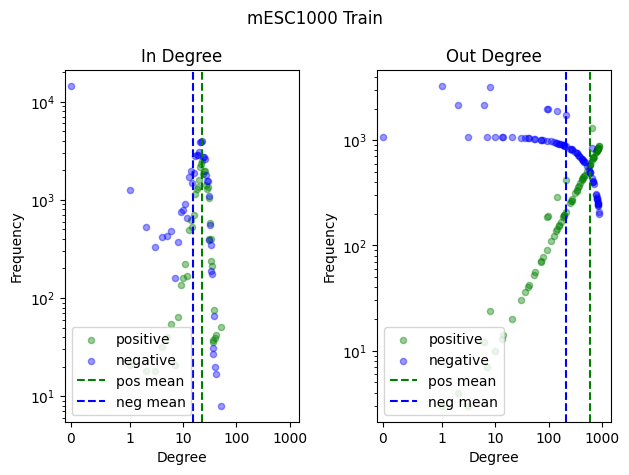

In [21]:
import pandas as pd
train_edges = pd.read_csv("data/GNNLink_mESC1000_Train_set.csv", sep=",", header=0, index_col=0)
pos_train_edges = train_edges[train_edges.Label == 1]
neg_train_edges = train_edges[train_edges.Label == 0]
pos_train_edges_tensor = torch.LongTensor((pos_train_edges.TF.values,(pos_train_edges.Target.values)))
neg_train_edges_tensor = torch.LongTensor((neg_train_edges.TF.values,(neg_train_edges.Target.values)))

inspect_degree_bias(pos_train_edges_tensor, neg_train_edges_tensor, title="mESC1000 Train")

Mean out_degree positive edges: 684.4732427750935
Mean out_degree negative edges: 236.8635879674171
Mean in_degree positive edges: 26.224055672045463
Mean in_degree negative edges: 17.89601693284587


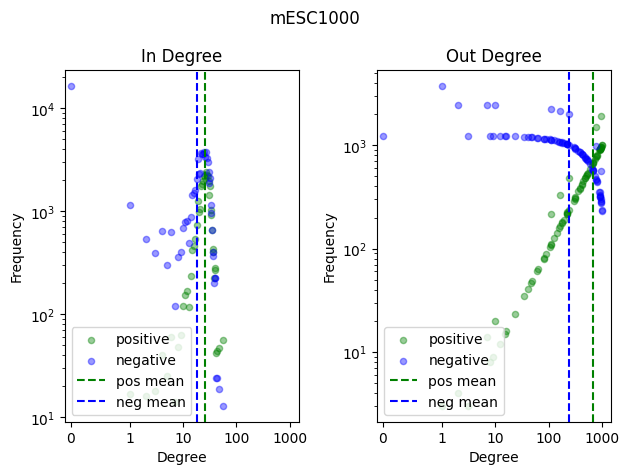

In [23]:
import pandas as pd
val_edges = pd.read_csv("data/GNNLink_mESC1000_Validation_set.csv", sep=",", header=0, index_col=0)
pos_val_edges = val_edges[val_edges.Label == 1]
neg_val_edges = val_edges[val_edges.Label == 0]
pos_val_edges_tensor = torch.LongTensor((pos_val_edges.TF.values,(pos_val_edges.Target.values)))
neg_val_edges_tensor = torch.LongTensor((neg_val_edges.TF.values,(neg_val_edges.Target.values)))

fig, ax = inspect_degree_bias(torch.hstack((pos_train_edges_tensor,pos_val_edges_tensor)), 
                    torch.hstack((neg_train_edges_tensor, neg_val_edges_tensor)), title="mESC1000")

fig.savefig("mESC1000trainandval.pdf")

In [10]:
test_edges = pd.read_csv("data/GNNLink_mESC1000_Test_set.csv", sep=",", header=0, index_col=0)
pos_test_edges = test_edges[test_edges.Label == 1]
neg_test_edges = test_edges[test_edges.Label == 0]
pos_test_edges_tensor = torch.LongTensor((pos_test_edges.TF.values,(pos_test_edges.Target.values)))
neg_test_edges_tensor = torch.LongTensor((neg_test_edges.TF.values,(neg_test_edges.Target.values)))

In [48]:
from src.nn.decoders import HarmonicDegreeSorter

sorter = HarmonicDegreeSorter()
z = torch.rand((max(pos_train_edges_tensor.max(), neg_train_edges_tensor.max()) + 1, 1))

pos_out = sorter(z, pos_test_edges_tensor, pos_edge_index=torch.hstack((pos_train_edges_tensor, pos_val_edges_tensor)))
neg_out = sorter(z, neg_test_edges_tensor, pos_edge_index=torch.hstack((pos_train_edges_tensor, pos_val_edges_tensor)))
truth = np.concatenate((np.ones_like(pos_out), np.zeros_like(neg_out)))
prediction = np.concatenate((pos_out.numpy(), neg_out.numpy()))

print("AUROC: {}".format(roc_auc_score(y_true = truth, y_score=prediction)))
print("AUPRC: {}".format(average_precision_score(y_true = truth, y_score=prediction)))

AUROC: 0.8358622787464146
AUPRC: 0.64374419668609


In [49]:
from src.nn.decoders import OutDegreeSorter

sorter = OutDegreeSorter()
z = torch.rand((max(pos_train_edges_tensor.max(), neg_train_edges_tensor.max()) + 1, 1))

pos_out = sorter(z, pos_test_edges_tensor, pos_edge_index=torch.hstack((pos_train_edges_tensor, pos_val_edges_tensor)))
neg_out = sorter(z, neg_test_edges_tensor, pos_edge_index=torch.hstack((pos_train_edges_tensor, pos_val_edges_tensor)))
truth = np.concatenate((np.ones_like(pos_out), np.zeros_like(neg_out)))
prediction = np.concatenate((pos_out.numpy(), neg_out.numpy()))

print("AUROC: {}".format(roc_auc_score(y_true = truth, y_score=prediction)))
print("AUPRC: {}".format(average_precision_score(y_true = truth, y_score=prediction)))

AUROC: 0.8634467225678554
AUPRC: 0.6894477714134675


In [50]:
from src.nn.decoders import DegreeSorter

sorter = DegreeSorter()
z = torch.rand((max(pos_train_edges_tensor.max(), neg_train_edges_tensor.max()) + 1, 1))

pos_out = sorter(z, pos_test_edges_tensor, pos_edge_index=torch.hstack((pos_train_edges_tensor, pos_val_edges_tensor)))
neg_out = sorter(z, neg_test_edges_tensor, pos_edge_index=torch.hstack((pos_train_edges_tensor, pos_val_edges_tensor)))
truth = np.concatenate((np.ones_like(pos_out), np.zeros_like(neg_out)))
prediction = np.concatenate((pos_out.numpy(), neg_out.numpy()))

print("AUROC: {}".format(roc_auc_score(y_true = truth, y_score=prediction)))
print("AUPRC: {}".format(average_precision_score(y_true = truth, y_score=prediction)))

AUROC: 0.6712052911290314
AUPRC: 0.40617732532110984


In [ ]:
len(set(pos_train_edges.TF.tolist() + pos_val_edges.TF.tolist() + pos_test_edges.TF.tolist()))  # to identify the set in the description of GNNLInk

# mESC500

In [24]:
import os
from pathlib import Path

for split in ["Train", "Validation", "Test"]:
    my_file = Path("data/GNNLink_mESC500_{0}_set.csv".format(split))
    if not my_file.is_file():
        os.system('wget -O data/GNNLink_mESC500_{0}_set.csv https://raw.githubusercontent.com/sdesignates/GNNLink/refs/heads/master/Data/Train_validation_test/mESC%20500/{0}_set.csv'.format(split))

Mean out_degree positive edges: 416.2687976569207
Mean out_degree negative edges: 142.8452659897596
Mean in_degree positive edges: 22.4472049689441
Mean in_degree negative edges: 15.7465286817669


(<Figure size 640x480 with 2 Axes>,
 array([<Axes: title={'center': 'In Degree'}, xlabel='Degree', ylabel='Frequency'>,
        <Axes: title={'center': 'Out Degree'}, xlabel='Degree', ylabel='Frequency'>],
       dtype=object))

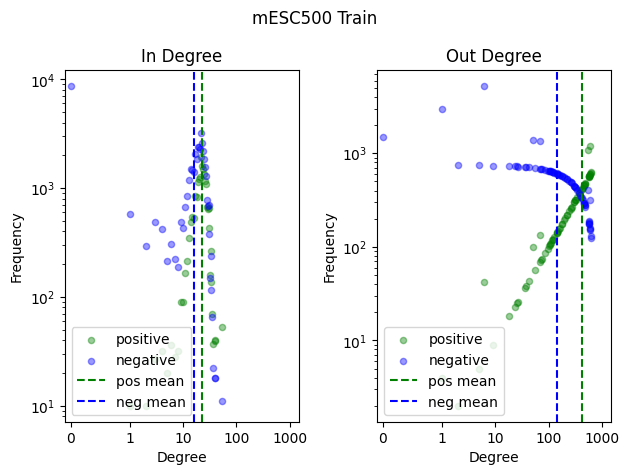

In [25]:
import pandas as pd
train_edges = pd.read_csv("data/GNNLink_mESC500_Train_set.csv", sep=",", header=0, index_col=0)
pos_train_edges = train_edges[train_edges.Label == 1]
neg_train_edges = train_edges[train_edges.Label == 0]
pos_train_edges_tensor = torch.LongTensor((pos_train_edges.TF.values,(pos_train_edges.Target.values)))
neg_train_edges_tensor = torch.LongTensor((neg_train_edges.TF.values,(neg_train_edges.Target.values)))

inspect_degree_bias(pos_train_edges_tensor, neg_train_edges_tensor, title="mESC500 Train")

Mean out_degree positive edges: 478.4743178522782
Mean out_degree negative edges: 164.20090608777724
Mean in_degree positive edges: 25.640625686541586
Mean in_degree negative edges: 18.104898537045777


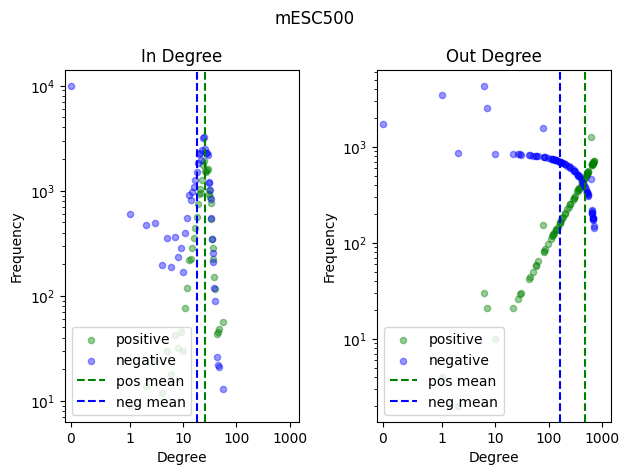

In [26]:
import pandas as pd
val_edges = pd.read_csv("data/GNNLink_mESC500_Validation_set.csv", sep=",", header=0, index_col=0)
pos_val_edges = val_edges[val_edges.Label == 1]
neg_val_edges = val_edges[val_edges.Label == 0]
pos_val_edges_tensor = torch.LongTensor((pos_val_edges.TF.values,(pos_val_edges.Target.values)))
neg_val_edges_tensor = torch.LongTensor((neg_val_edges.TF.values,(neg_val_edges.Target.values)))

fig, ax = inspect_degree_bias(torch.hstack((pos_train_edges_tensor,pos_val_edges_tensor)), 
                    torch.hstack((neg_train_edges_tensor, neg_val_edges_tensor)), title="mESC500")

fig.savefig("mESC500trainandval.pdf")

In [27]:
test_edges = pd.read_csv("data/GNNLink_mESC500_Test_set.csv", sep=",", header=0, index_col=0)
pos_test_edges = test_edges[test_edges.Label == 1]
neg_test_edges = test_edges[test_edges.Label == 0]
pos_test_edges_tensor = torch.LongTensor((pos_test_edges.TF.values,(pos_test_edges.Target.values)))
neg_test_edges_tensor = torch.LongTensor((neg_test_edges.TF.values,(neg_test_edges.Target.values)))

In [28]:
from src.nn.decoders import HarmonicDegreeSorter

sorter = HarmonicDegreeSorter()
z = torch.rand((max(pos_train_edges_tensor.max(), neg_train_edges_tensor.max()) + 1, 1))

pos_out = sorter(z, pos_test_edges_tensor, pos_edge_index=torch.hstack((pos_train_edges_tensor, pos_val_edges_tensor)))
neg_out = sorter(z, neg_test_edges_tensor, pos_edge_index=torch.hstack((pos_train_edges_tensor, pos_val_edges_tensor)))
truth = np.concatenate((np.ones_like(pos_out), np.zeros_like(neg_out)))
prediction = np.concatenate((pos_out.numpy(), neg_out.numpy()))

print("AUROC: {}".format(roc_auc_score(y_true = truth, y_score=prediction)))
print("AUPRC: {}".format(average_precision_score(y_true = truth, y_score=prediction)))

AUROC: 0.8416743045968594
AUPRC: 0.6641900564793881


In [30]:
from src.nn.decoders import OutDegreeSourceSorter

sorter = OutDegreeSourceSorter()
z = torch.rand((max(pos_train_edges_tensor.max(), neg_train_edges_tensor.max()) + 1, 1))

pos_out = sorter(z, pos_test_edges_tensor, pos_edge_index=torch.hstack((pos_train_edges_tensor, pos_val_edges_tensor)))
neg_out = sorter(z, neg_test_edges_tensor, pos_edge_index=torch.hstack((pos_train_edges_tensor, pos_val_edges_tensor)))
truth = np.concatenate((np.ones_like(pos_out), np.zeros_like(neg_out)))
prediction = np.concatenate((pos_out.numpy(), neg_out.numpy()))

print("AUROC: {}".format(roc_auc_score(y_true = truth, y_score=prediction)))
print("AUPRC: {}".format(average_precision_score(y_true = truth, y_score=prediction)))

AUROC: 0.8639094580661649
AUPRC: 0.7006206496497819


In [31]:
from src.nn.decoders import InDegreeTargetSorter

sorter = InDegreeTargetSorter()
z = torch.rand((max(pos_train_edges_tensor.max(), neg_train_edges_tensor.max()) + 1, 1))

pos_out = sorter(z, pos_test_edges_tensor, pos_edge_index=torch.hstack((pos_train_edges_tensor, pos_val_edges_tensor)))
neg_out = sorter(z, neg_test_edges_tensor, pos_edge_index=torch.hstack((pos_train_edges_tensor, pos_val_edges_tensor)))
truth = np.concatenate((np.ones_like(pos_out), np.zeros_like(neg_out)))
prediction = np.concatenate((pos_out.numpy(), neg_out.numpy()))

print("AUROC: {}".format(roc_auc_score(y_true = truth, y_score=prediction)))
print("AUPRC: {}".format(average_precision_score(y_true = truth, y_score=prediction)))

AUROC: 0.6614425624587715
AUPRC: 0.4040515067123009


# hESC 500

In [32]:
import os
from pathlib import Path

for split in ["Train", "Validation", "Test"]:
    my_file = Path("data/GNNLink_hESC500_{0}_set.csv".format(split))
    if not my_file.is_file():
        os.system('wget -O data/GNNLink_hESC500_{0}_set.csv https://raw.githubusercontent.com/sdesignates/GNNLink/refs/heads/master/Data/Train_validation_test/hESC%20500/{0}_set.csv'.format(split))

Mean out_degree positive edges: 219.26402640264027
Mean out_degree negative edges: 66.76211254037513
Mean in_degree positive edges: 5.193729372937294
Mean in_degree negative edges: 3.0521335071116904


(<Figure size 640x480 with 2 Axes>,
 array([<Axes: title={'center': 'In Degree'}, xlabel='Degree', ylabel='Frequency'>,
        <Axes: title={'center': 'Out Degree'}, xlabel='Degree', ylabel='Frequency'>],
       dtype=object))

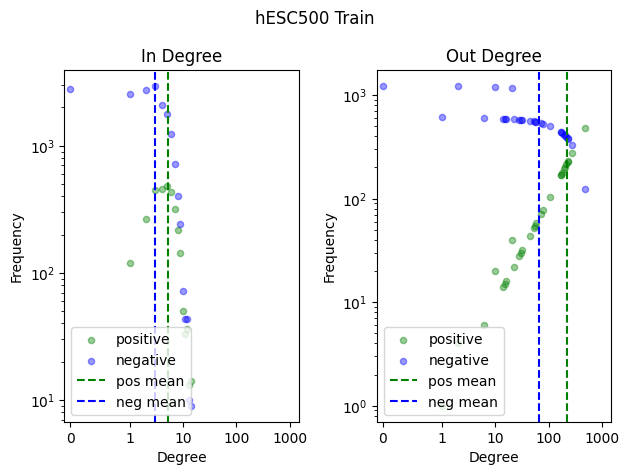

In [33]:
import pandas as pd
train_edges = pd.read_csv("data/GNNLink_hESC500_Train_set.csv", sep=",", header=0, index_col=0)
pos_train_edges = train_edges[train_edges.Label == 1]
neg_train_edges = train_edges[train_edges.Label == 0]
pos_train_edges_tensor = torch.LongTensor((pos_train_edges.TF.values,(pos_train_edges.Target.values)))
neg_train_edges_tensor = torch.LongTensor((neg_train_edges.TF.values,(neg_train_edges.Target.values)))

inspect_degree_bias(pos_train_edges_tensor, neg_train_edges_tensor, title="hESC500 Train")

Mean out_degree positive edges: 252.1739380022962
Mean out_degree negative edges: 76.73106508875739
Mean in_degree positive edges: 5.8369690011481055
Mean in_degree negative edges: 3.5028599605522683


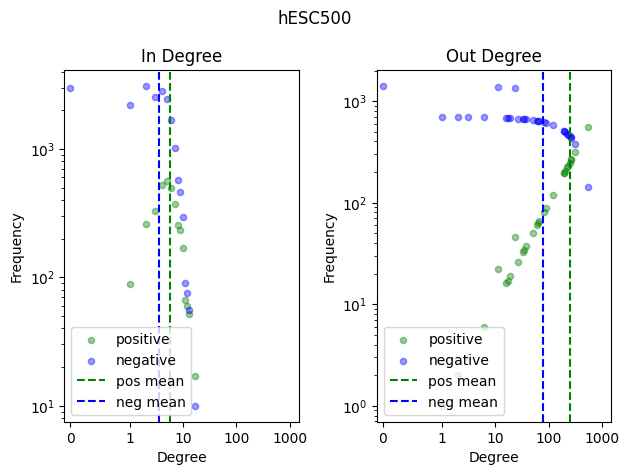

In [34]:
import pandas as pd
val_edges = pd.read_csv("data/GNNLink_hESC500_Validation_set.csv", sep=",", header=0, index_col=0)
pos_val_edges = val_edges[val_edges.Label == 1]
neg_val_edges = val_edges[val_edges.Label == 0]
pos_val_edges_tensor = torch.LongTensor((pos_val_edges.TF.values,(pos_val_edges.Target.values)))
neg_val_edges_tensor = torch.LongTensor((neg_val_edges.TF.values,(neg_val_edges.Target.values)))

fig, ax = inspect_degree_bias(torch.hstack((pos_train_edges_tensor,pos_val_edges_tensor)), 
                    torch.hstack((neg_train_edges_tensor, neg_val_edges_tensor)), title="hESC500")

fig.savefig("hESC500trainandval.pdf")

In [35]:
test_edges = pd.read_csv("data/GNNLink_hESC500_Test_set.csv", sep=",", header=0, index_col=0)
pos_test_edges = test_edges[test_edges.Label == 1]
neg_test_edges = test_edges[test_edges.Label == 0]
pos_test_edges_tensor = torch.LongTensor((pos_test_edges.TF.values,(pos_test_edges.Target.values)))
neg_test_edges_tensor = torch.LongTensor((neg_test_edges.TF.values,(neg_test_edges.Target.values)))

In [36]:
from src.nn.decoders import HarmonicDegreeSorter

sorter = HarmonicDegreeSorter()
z = torch.rand((max(pos_train_edges_tensor.max(), neg_train_edges_tensor.max()) + 1, 1))

pos_out = sorter(z, pos_test_edges_tensor, pos_edge_index=torch.hstack((pos_train_edges_tensor, pos_val_edges_tensor)))
neg_out = sorter(z, neg_test_edges_tensor, pos_edge_index=torch.hstack((pos_train_edges_tensor, pos_val_edges_tensor)))
truth = np.concatenate((np.ones_like(pos_out), np.zeros_like(neg_out)))
prediction = np.concatenate((pos_out.numpy(), neg_out.numpy()))

print("AUROC: {}".format(roc_auc_score(y_true = truth, y_score=prediction)))
print("AUPRC: {}".format(average_precision_score(y_true = truth, y_score=prediction)))

AUROC: 0.7509819913108319
AUPRC: 0.34183376014356925


In [37]:
from src.nn.decoders import OutDegreeSourceSorter

sorter = OutDegreeSourceSorter()
z = torch.rand((max(pos_train_edges_tensor.max(), neg_train_edges_tensor.max()) + 1, 1))

pos_out = sorter(z, pos_test_edges_tensor, pos_edge_index=torch.hstack((pos_train_edges_tensor, pos_val_edges_tensor)))
neg_out = sorter(z, neg_test_edges_tensor, pos_edge_index=torch.hstack((pos_train_edges_tensor, pos_val_edges_tensor)))
truth = np.concatenate((np.ones_like(pos_out), np.zeros_like(neg_out)))
prediction = np.concatenate((pos_out.numpy(), neg_out.numpy()))

print("AUROC: {}".format(roc_auc_score(y_true = truth, y_score=prediction)))
print("AUPRC: {}".format(average_precision_score(y_true = truth, y_score=prediction)))

AUROC: 0.8440062455623819
AUPRC: 0.48156508899339834


In [38]:
from src.nn.decoders import InDegreeTargetSorter

sorter = InDegreeTargetSorter()
z = torch.rand((max(pos_train_edges_tensor.max(), neg_train_edges_tensor.max()) + 1, 1))

pos_out = sorter(z, pos_test_edges_tensor, pos_edge_index=torch.hstack((pos_train_edges_tensor, pos_val_edges_tensor)))
neg_out = sorter(z, neg_test_edges_tensor, pos_edge_index=torch.hstack((pos_train_edges_tensor, pos_val_edges_tensor)))
truth = np.concatenate((np.ones_like(pos_out), np.zeros_like(neg_out)))
prediction = np.concatenate((pos_out.numpy(), neg_out.numpy()))

print("AUROC: {}".format(roc_auc_score(y_true = truth, y_score=prediction)))
print("AUPRC: {}".format(average_precision_score(y_true = truth, y_score=prediction)))

AUROC: 0.647029165331797
AUPRC: 0.21393522113536162
